In [ ]:
!pip install ultralytics

In [1]:
import pandas as pd
import numpy as np

from ultralytics import YOLO

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import plotly.express as px
import plotly.graph_objects as go

from PIL import Image

import os
import yaml
from pathlib import Path

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\rustem_izmailov\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Data Injection

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farukalam/tomato-leaf-diseases-detection-computer-vision")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/farukalam/tomato-leaf-diseases-detection-computer-vision/versions/1


In [4]:
files = os.listdir(path)
print("Files in the dataset directory:", files)
print("Files in the 'train' directory:",os.listdir(path+'/train'))

Files in the dataset directory: ['train', 'README.roboflow.txt', 'data.yaml', 'valid', 'test', 'README.dataset.txt']
Files in the 'train' directory: ['labels', 'images', 'labels.cache']


In [5]:
data_yaml_path = os.path.join(path, 'data.yaml')
with open(os.path.join(path, 'data.yaml'), 'r') as file:
    data_yaml = yaml.safe_load(file)

nc = data_yaml['nc']
class_names = data_yaml['names']

In [6]:
train_path = os.path.join(path, 'train', 'images')
val_path = os.path.join(path, 'valid', 'images')
test_path = os.path.join(path, 'test', 'images')

train_labels_path = os.path.join(path, 'train', 'labels')
val_labels_path = os.path.join(path, 'valid', 'labels')
test_labels_path = os.path.join(path, 'test', 'labels')

# EDA

In [32]:
def load_labels(path):
    labels = []
    for label_file in Path(path).glob('*.txt'):
        with open(label_file, 'r') as file:
            for line in file:
                labels.append(int(line.split()[0]))
    return labels


# Load labels for train, validation, and test sets
train_labels = load_labels(train_labels_path)
val_labels = load_labels(val_labels_path)
test_labels = load_labels(test_labels_path)

# Combine labels and create a count series
labels = train_labels + val_labels + test_labels
labels_count = pd.Series(labels).value_counts().sort_index()
labels_count.index = [class_names[i] for i in labels_count.index]

# Plot class distribution
fig = px.bar(labels_count, title="Class Distribution", labels={'index': 'Class', 'value': 'Count'},
             template='plotly_white', color=labels_count, color_continuous_scale='reds')

fig.show()

# Data Preprocessing

In [84]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)


def load_labels_with_image_paths(images_path, labels_path):
    images, labels = [], []
    for label_file in Path(labels_path).glob('*.txt'):
        with open(label_file, 'r') as file:
            label_lines = file.readlines()
        if label_lines:
            img_path = images_path +'/'+ (label_file.stem + '.jpg')
            images.append(str(img_path))
            labels.append([list(map(float, line.split())) for line in label_lines])
    return images, labels


train_images, train_labels = load_labels_with_image_paths(train_path, train_labels_path)
val_images, val_labels = load_labels_with_image_paths(val_path, val_labels_path)
test_images, test_labels = load_labels_with_image_paths(test_path, test_labels_path)

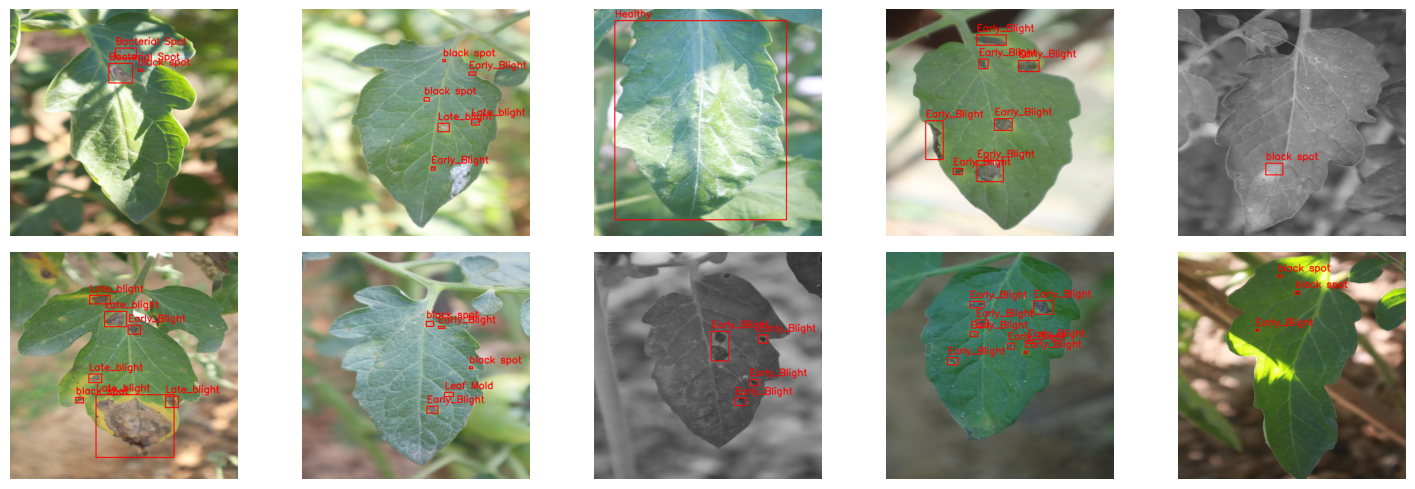

In [9]:
def plot_image_with_boxes(img_path, labels, class_names, ax):
    # Load image (assuming load_image is defined elsewhere)
    img = load_image(img_path)
    h, w, _ = img.shape
    for label in labels:
        class_idx, x, y, box_w, box_h = label
        box_w, box_h = int(box_w * w), int(box_h * h)
        x, y = int(x * w - box_w / 2), int(y * h - box_h / 2)
        img = cv2.rectangle(img, (x, y), (x + box_w, y + box_h), (255, 0, 0), 2)
        img = cv2.putText(img, class_names[int(class_idx)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image on the specified axis
    ax.imshow(img)
    ax.axis('off')


# Set up the subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
for i in range(2):
    for j in range(5):
        img_idx = np.random.randint(0, len(train_images))
        plot_image_with_boxes(train_images[img_idx], train_labels[img_idx], class_names, axs[i, j])

plt.tight_layout()  # To prevent overlap
plt.show()


In [10]:
model = YOLO("yolo11n.pt")

@software{yolo11_ultralytics,

  author = {Glenn Jocher and Jing Qiu},

  title = {Ultralytics YOLO11},

  version = {11.0.0},

  year = {2024},

  url = {https://github.com/ultralytics/ultralytics},

  orcid = {0000-0001-5950-6979, 0000-0002-7603-6750, 0000-0003-3783-7069},
  
  license = {AGPL-3.0}
}

In [11]:
results = []
learning_rates = [0.1, 0.01, 0.001]
run_names = ['yolo11n_lr_01', 'yolo11n_lr_001', 'yolo11n_lr_0001']

for lr, run_name in zip(learning_rates, run_names):
    result = model.train(data=data_yaml_path, epochs=100, batch = 96, imgsz=640, lr0=lr, name=run_name, seed = 42, plots = True)
    results.append(result)

Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/root/.cache/kagglehub/datasets/farukalam/tomato-leaf-diseases-detection-computer-vision/versions/1/data.yaml, epochs=100, time=None, patience=100, batch=96, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11n_lr_01, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, s

train: Scanning /root/.cache/kagglehub/datasets/farukalam/tomato-leaf-diseases-detection-computer-vision/versions/1/train/labels.cache... 645 images, 18 backgrounds, 0 corrupt: 100%|██████████| 645/645 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning:

A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.

val: Scanning /root/.cache/kagglehub/datasets/farukalam/tomato-leaf-diseases-detection-computer-vision/versions/1/valid/labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11n_lr_01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00075), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11n_lr_01
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.1G      1.555      4.381      1.399        291        640: 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         61        196    0.00132      0.159     0.0155     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      13.2G      1.427      4.126       1.28        457        640: 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         61        196    0.00157      0.169     0.0849     0.0677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100        13G       1.36      3.386       1.25        291        640: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         61        196    0.00348      0.185      0.124      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.3G      1.394      2.809      1.232        353        640: 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         61        196    0.00668      0.296       0.13     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.5G      1.325      2.386      1.192        277        640: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         61        196    0.00455      0.253      0.148      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.2G      1.322       2.12      1.185        343        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         61        196      0.988     0.0796      0.144     0.0972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.3G       1.29      2.023      1.161        329        640: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         61        196      0.989     0.0918      0.143      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.5G      1.252      1.809      1.153        344        640: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         61        196          1     0.0527      0.153      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.4G      1.271      1.764      1.143        361        640: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         61        196      0.978     0.0911      0.179      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.4G      1.233      1.659       1.13        422        640: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         61        196      0.928      0.108      0.171      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.1G      1.214      1.673      1.118        325        640: 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         61        196      0.933     0.0975      0.181      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.2G      1.201      1.573      1.108        302        640: 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         61        196      0.929       0.12      0.225      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.2G      1.185      1.555      1.112        318        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         61        196      0.922      0.143      0.207       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.4G      1.226      1.486      1.123        311        640: 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         61        196      0.947     0.0902      0.248      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.2G      1.216      1.461      1.116        317        640: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         61        196      0.934      0.115      0.242      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.5G      1.236      1.403      1.118        386        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         61        196       0.82      0.218      0.292      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.3G      1.159      1.335      1.097        312        640: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         61        196       0.96      0.148      0.268      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.3G      1.208       1.36      1.112        304        640: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         61        196      0.762      0.178      0.247      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      13.2G      1.222      1.354      1.113        262        640: 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         61        196      0.769      0.167      0.243      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      13.1G      1.186      1.276      1.091        418        640: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         61        196      0.617      0.321      0.368      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      13.4G      1.119      1.228      1.079        379        640: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         61        196      0.628      0.348      0.367      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      13.6G      1.114      1.151      1.081        312        640: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         61        196       0.66      0.317      0.411      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      13.1G      1.128      1.132      1.091        290        640: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         61        196      0.568      0.384      0.414      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      13.3G      1.136      1.129      1.069        336        640: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         61        196      0.641      0.469      0.461        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      13.6G      1.117      1.101      1.059        365        640: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         61        196      0.534      0.447      0.427       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      13.1G      1.094      1.068      1.054        358        640: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         61        196      0.663      0.416      0.472      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      13.4G      1.051      1.014      1.048        305        640: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         61        196      0.507      0.356      0.395      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      13.5G      1.073      1.039      1.075        274        640: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         61        196      0.447      0.482      0.506      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.1G      1.031     0.9727      1.063        288        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         61        196      0.549      0.443       0.45      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      13.6G      1.045     0.9568      1.037        284        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         61        196      0.637      0.319       0.38      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      13.3G      1.057      0.949      1.034        355        640: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         61        196      0.606      0.442      0.438      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      13.4G      1.021     0.9138       1.02        319        640: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         61        196      0.634      0.497      0.528      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.1G      1.061     0.9242      1.042        310        640: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         61        196      0.778      0.461      0.557       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.2G      1.029     0.9018       1.03        333        640: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         61        196       0.69      0.568      0.604      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.1G     0.9912     0.8585      1.026        277        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         61        196      0.399      0.542      0.516      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      13.4G      1.029     0.8498      1.032        310        640: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         61        196      0.681      0.618      0.645      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      13.2G      1.046     0.8492      1.044        386        640: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         61        196      0.668      0.561      0.637      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      13.5G     0.9985     0.8386      1.041        311        640: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         61        196      0.595      0.663      0.637      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.1G     0.9431     0.8046      1.009        332        640: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         61        196      0.648      0.597      0.614      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.2G      1.001     0.8257      1.017        362        640: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         61        196      0.645      0.571      0.614      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      13.4G     0.9863     0.8056      1.004        378        640: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         61        196      0.642       0.53      0.571      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      13.2G     0.9985     0.8012      1.013        337        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         61        196      0.435      0.516      0.553      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      13.2G     0.9824     0.7817      1.005        332        640: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         61        196      0.496      0.545      0.595      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.3G     0.9697     0.7666      1.006        337        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         61        196      0.822      0.512      0.619      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.1G     0.9665     0.7563      0.993        353        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         61        196      0.704      0.616       0.64      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.4G     0.9298     0.7369     0.9881        356        640: 100%|██████████| 7/7 [00:09<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         61        196       0.62      0.589      0.619      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      13.4G     0.9203     0.7293     0.9904        337        640: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         61        196      0.574      0.634      0.623      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.4G     0.9475     0.7468      1.007        335        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         61        196      0.676      0.569      0.632      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      13.1G     0.9155     0.7165     0.9898        340        640: 100%|██████████| 7/7 [00:09<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         61        196       0.71      0.638      0.679      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      13.4G     0.9722     0.7538     0.9999        377        640: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         61        196      0.691      0.645      0.649       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      13.6G      0.926     0.7271     0.9761        393        640: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         61        196      0.667      0.674      0.648      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      13.2G     0.9364     0.7227     0.9855        277        640: 100%|██████████| 7/7 [00:10<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         61        196      0.633      0.689      0.646      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      13.1G      0.928     0.7149     0.9885        342        640: 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         61        196      0.612      0.703      0.676      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      13.4G     0.9066     0.6956     0.9897        327        640: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         61        196      0.652      0.737      0.675      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      13.3G     0.9257     0.7022      0.974        321        640: 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         61        196      0.645      0.664      0.683      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      13.1G     0.9336     0.6828       0.98        382        640: 100%|██████████| 7/7 [00:10<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         61        196      0.629      0.695      0.676      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      13.2G     0.9056      0.679     0.9667        311        640: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         61        196      0.653      0.662      0.666      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      13.3G     0.8907      0.659     0.9729        272        640: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         61        196      0.671      0.673      0.682      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      13.2G     0.8707     0.6471     0.9634        346        640: 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         61        196      0.691      0.712      0.704      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      13.2G     0.8678     0.6444     0.9643        330        640: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         61        196      0.706      0.709        0.7      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      13.2G     0.8823     0.6627     0.9736        331        640: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         61        196      0.729      0.707      0.709       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      13.3G     0.9048     0.6571     0.9697        378        640: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         61        196       0.79      0.739      0.744      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      13.1G     0.8782     0.6507     0.9625        350        640: 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         61        196      0.704      0.738       0.69       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      13.4G     0.8451     0.6264     0.9589        373        640: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         61        196        0.7       0.68      0.684      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      13.1G     0.8762     0.6478     0.9625        351        640: 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         61        196      0.658      0.731       0.66      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      13.4G     0.8809     0.6459     0.9763        337        640: 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         61        196      0.668      0.741      0.679      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      13.1G     0.8599     0.6251     0.9677        309        640: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         61        196      0.711      0.728       0.68      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      13.4G     0.8484     0.6166     0.9624        358        640: 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         61        196        0.7      0.754      0.731      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      13.4G     0.8209     0.5995      0.952        339        640: 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         61        196      0.713      0.759      0.744      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      13.1G     0.8413     0.6152     0.9487        311        640: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         61        196      0.693      0.682      0.715      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      13.4G     0.7992     0.5903       0.95        340        640: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         61        196      0.709      0.649      0.697      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      13.2G     0.8189     0.6032     0.9498        360        640: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         61        196      0.677      0.711      0.695       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      13.3G     0.8241     0.6067     0.9501        355        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         61        196      0.706      0.722      0.711      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      13.3G     0.8025     0.5722     0.9397        337        640: 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         61        196      0.682        0.8      0.725       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      13.4G     0.8042     0.5774     0.9346        357        640: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         61        196      0.717      0.712      0.708      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      13.1G     0.8165     0.5839     0.9479        333        640: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         61        196      0.692      0.783      0.739      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      13.2G     0.8001     0.5636     0.9434        294        640: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         61        196      0.682      0.743      0.725      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      13.2G     0.7936     0.5645     0.9443        365        640: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         61        196      0.731      0.745      0.729      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      13.3G     0.7919      0.558      0.939        359        640: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         61        196      0.735      0.738      0.725       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      13.5G     0.8003     0.5831     0.9411        307        640: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         61        196      0.753      0.715       0.74      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      13.4G      0.794     0.5857     0.9452        320        640: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         61        196      0.693      0.636      0.691      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      13.2G     0.7955     0.5715     0.9436        324        640: 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         61        196      0.617      0.693      0.659      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      13.2G     0.7824      0.558     0.9278        329        640: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         61        196      0.725      0.715      0.717      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      13.3G     0.7766      0.569     0.9339        367        640: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         61        196      0.675      0.753      0.721      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      13.5G      0.802     0.5646     0.9331        331        640: 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         61        196      0.648      0.754      0.672       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      13.4G     0.7543     0.5268     0.9341        301        640: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         61        196      0.705       0.74      0.687      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      13.4G     0.7476     0.5338     0.9205        331        640: 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         61        196      0.708      0.762        0.7       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      13.2G       0.74     0.5229     0.9232        306        640: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         61        196      0.695      0.764      0.696      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      13.4G     0.7649     0.5333      0.924        414        640: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         61        196      0.715      0.746      0.719      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      13.1G     0.7813     0.5503     0.9238        335        640: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         61        196      0.735      0.742      0.715      0.476


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      13.3G     0.8598      0.601     0.9372        223        640: 100%|██████████| 7/7 [00:14<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         61        196      0.757      0.694      0.717      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      13.3G     0.8481     0.5806     0.9288        211        640: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         61        196       0.76       0.72      0.729      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      13.3G     0.8246     0.5663     0.9127        210        640: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         61        196      0.771      0.718      0.743      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      13.3G     0.8331     0.5708     0.9285        229        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         61        196      0.738       0.75      0.732      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      13.3G     0.7998     0.5583     0.9319        205        640: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         61        196       0.74      0.781      0.735      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      13.3G     0.8063     0.5545     0.9135        216        640: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         61        196      0.743      0.785       0.73       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      13.1G     0.7968     0.5451     0.9155        182        640: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         61        196      0.748      0.739      0.732      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      13.3G     0.7906     0.5428     0.9084        239        640: 100%|██████████| 7/7 [00:10<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         61        196      0.751      0.767      0.738      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      13.3G     0.7854     0.5374      0.902        220        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         61        196      0.753      0.771      0.732      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100        13G     0.7817     0.5413     0.9176        242        640: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         61        196      0.723      0.757      0.733      0.485



100 epochs completed in 0.355 hours.
Optimizer stripped from runs/detect/yolo11n_lr_01/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11n_lr_01/weights/best.pt, 5.5MB

Validating runs/detect/yolo11n_lr_01/weights/best.pt...
Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


                   all         61        196      0.789       0.74      0.744      0.494
        Bacterial Spot          3          4      0.863       0.75      0.747        0.4
          Early_Blight         31         96      0.773       0.85       0.81      0.462
               Healthy         19         19      0.957      0.947      0.993      0.949
           Late_blight         13         29      0.841       0.91      0.918      0.735
             Leaf Mold          4          7       0.52      0.429       0.48       0.21
           Target_Spot          5          6      0.811      0.833      0.729      0.446
            black spot         21         35       0.76      0.457      0.533      0.256
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/yolo11n_lr_01
Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/root/.cache/kagg

train: Scanning /root/.cache/kagglehub/datasets/farukalam/tomato-leaf-diseases-detection-computer-vision/versions/1/train/labels.cache... 645 images, 18 backgrounds, 0 corrupt: 100%|██████████| 645/645 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /root/.cache/kagglehub/datasets/farukalam/tomato-leaf-diseases-detection-computer-vision/versions/1/valid/labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11n_lr_001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00075), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11n_lr_001
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.2G     0.8652     0.6512     0.9649        291        640: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         61        196      0.793      0.752      0.756      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      13.2G     0.8284     0.6219     0.9423        457        640: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         61        196      0.814      0.715      0.745      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.1G     0.8115     0.5897     0.9558        291        640: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         61        196      0.762      0.691      0.712      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.3G     0.8312      0.604      0.952        353        640: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         61        196      0.735       0.69      0.699      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.5G     0.8169     0.6192     0.9429        277        640: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         61        196      0.716       0.73      0.711      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.2G     0.8516     0.6175     0.9604        343        640: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         61        196      0.691      0.736      0.711      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.4G     0.8684     0.6292     0.9542        329        640: 100%|██████████| 7/7 [00:09<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         61        196      0.745      0.753      0.713       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.6G     0.8523     0.6157     0.9673        344        640: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         61        196      0.625      0.724      0.687      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.4G     0.8813     0.6416     0.9628        361        640: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         61        196      0.682      0.735      0.735      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.4G     0.8648      0.631     0.9611        422        640: 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         61        196      0.616       0.59      0.622      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.1G     0.8769     0.6708     0.9675        325        640: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         61        196      0.548       0.64       0.63      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.2G     0.9019     0.6733     0.9704        302        640: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         61        196      0.732      0.563      0.682      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.2G     0.8724     0.6838     0.9689        318        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         61        196      0.608      0.699      0.643      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.4G     0.9301     0.6804     0.9893        311        640: 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         61        196      0.628      0.657      0.631      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.2G     0.9056     0.6798     0.9831        317        640: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         61        196      0.526       0.68       0.56      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.5G     0.9245     0.6836     0.9797        386        640: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         61        196      0.689      0.605      0.613      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.3G     0.8874     0.6766     0.9773        312        640: 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         61        196      0.518      0.639      0.577      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.3G     0.9481     0.6958     0.9894        304        640: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         61        196      0.601      0.549      0.575      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      13.2G     0.9513     0.6982     0.9927        262        640: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         61        196      0.682      0.513      0.574      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      13.2G     0.9332     0.6739     0.9843        418        640: 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         61        196      0.583      0.641       0.64      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      13.5G     0.9104      0.687     0.9864        379        640: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         61        196      0.583      0.645      0.631      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      13.6G     0.8972     0.6727      0.982        312        640: 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         61        196      0.539      0.649      0.655      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      13.1G     0.9139     0.6483     0.9923        290        640: 100%|██████████| 7/7 [00:10<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         61        196      0.624      0.579      0.576      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      13.3G     0.9228     0.6793      0.977        336        640: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         61        196      0.609      0.553      0.553      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      13.6G      0.901      0.663     0.9695        365        640: 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         61        196      0.792      0.477       0.58      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      13.2G     0.8987     0.6631     0.9662        358        640: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         61        196      0.651      0.555      0.577      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      13.4G     0.8555     0.6309     0.9663        305        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         61        196      0.537      0.632      0.648      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      13.6G      0.886     0.6457     0.9849        274        640: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         61        196      0.677      0.604      0.643      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.1G     0.8607      0.619     0.9819        288        640: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         61        196       0.62      0.676       0.65       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      13.6G     0.8786     0.6062     0.9748        284        640: 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         61        196      0.682      0.566      0.618      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      13.3G      0.878     0.6251      0.957        355        640: 100%|██████████| 7/7 [00:09<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         61        196      0.724      0.577      0.586      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      13.4G     0.8655     0.6138     0.9532        319        640: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         61        196      0.701      0.616      0.629      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.2G     0.8823     0.6079     0.9725        310        640: 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         61        196      0.666      0.637      0.632      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.2G     0.8624     0.6044     0.9608        333        640: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         61        196      0.605      0.516      0.598      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.1G     0.8215     0.5833     0.9589        277        640: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         61        196      0.625      0.692      0.658      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      13.5G     0.8454     0.5793     0.9616        310        640: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         61        196      0.726      0.648      0.679       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      13.2G      0.882     0.5937     0.9726        386        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         61        196       0.57      0.661      0.628      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      13.5G     0.8541     0.5867     0.9722        311        640: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         61        196        0.6       0.63      0.632      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.1G     0.8077     0.5687     0.9498        332        640: 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         61        196      0.815      0.553      0.668      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.2G     0.8561     0.5836     0.9551        362        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         61        196      0.663      0.673      0.718      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      13.1G     0.8326     0.5799     0.9451        378        640: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         61        196      0.714      0.617      0.669      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      13.2G     0.8635     0.5998     0.9608        337        640: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         61        196      0.632      0.633      0.649       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      13.3G     0.8463     0.5756     0.9501        332        640: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         61        196      0.662      0.717      0.664       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.3G     0.8353     0.5569     0.9466        337        640: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         61        196      0.665      0.613      0.637      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.1G     0.8189     0.5612     0.9345        353        640: 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         61        196      0.604      0.673      0.635      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.4G     0.8019     0.5481     0.9371        356        640: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         61        196       0.66      0.762      0.692      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      13.4G     0.7988     0.5455     0.9443        337        640: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         61        196      0.757      0.776      0.763      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.4G     0.8054     0.5569     0.9519        335        640: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         61        196      0.735      0.749       0.73      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      13.1G     0.7945     0.5461     0.9436        340        640: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         61        196      0.586      0.784      0.692      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      13.4G     0.8236     0.5589     0.9401        377        640: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         61        196      0.662      0.786      0.724      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      13.6G     0.7985     0.5549     0.9273        393        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         61        196      0.735      0.726      0.697      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      13.2G     0.8126     0.5542      0.939        277        640: 100%|██████████| 7/7 [00:09<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         61        196       0.63      0.761      0.694      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      13.2G     0.7942     0.5628     0.9342        342        640: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         61        196      0.653      0.638      0.673      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      13.4G     0.7846      0.542     0.9425        327        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         61        196       0.68       0.75      0.698       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      13.3G     0.8093     0.5547      0.932        321        640: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         61        196      0.597      0.746      0.664      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      13.2G     0.8152     0.5469     0.9334        382        640: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         61        196      0.638      0.675      0.675      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      13.2G     0.7908     0.5395     0.9257        311        640: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         61        196       0.76      0.703       0.73      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      13.2G     0.7738     0.5236     0.9261        272        640: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         61        196      0.711      0.709       0.74      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      13.2G     0.7754     0.5148     0.9257        346        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         61        196      0.782      0.746      0.775      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      13.2G     0.7541     0.5123     0.9198        330        640: 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         61        196      0.728      0.602      0.691      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      13.2G     0.7651     0.5244      0.932        331        640: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         61        196       0.67      0.717      0.723      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      13.3G     0.8011     0.5201      0.938        378        640: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         61        196       0.74      0.756      0.754      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      13.1G     0.7817     0.5253     0.9284        350        640: 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         61        196      0.625      0.776       0.69      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      13.4G     0.7478      0.502     0.9231        373        640: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         61        196      0.761      0.669      0.697      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      13.1G     0.7883       0.53     0.9292        351        640: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         61        196      0.747      0.754      0.723      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      13.5G     0.7806     0.5201     0.9364        337        640: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         61        196      0.743      0.748      0.726      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      13.1G      0.756     0.5077     0.9319        309        640: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         61        196        0.7       0.69      0.703       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      13.2G     0.7525     0.4965     0.9266        358        640: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         61        196        0.7      0.724      0.726      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      13.4G     0.7322     0.4867     0.9205        339        640: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         61        196      0.739       0.74      0.739      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      13.1G     0.7473     0.5019     0.9183        311        640: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         61        196      0.786      0.733      0.731      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      13.4G     0.6964     0.4785     0.9154        340        640: 100%|██████████| 7/7 [00:12<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         61        196      0.723      0.737       0.73      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      13.2G     0.7356     0.4959       0.92        360        640: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         61        196      0.754      0.744      0.747      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      13.3G     0.7342      0.495     0.9187        355        640: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         61        196      0.758      0.794      0.733      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      13.3G     0.7217     0.4728     0.9106        337        640: 100%|██████████| 7/7 [00:10<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         61        196      0.716      0.784      0.733      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      13.2G     0.7231     0.4862     0.9089        357        640: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         61        196      0.798      0.728      0.762      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      13.3G     0.7262     0.4774      0.917        333        640: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         61        196      0.733      0.778      0.742      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      13.2G     0.7228     0.4692     0.9177        294        640: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         61        196      0.713      0.754      0.745      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      13.2G     0.7163     0.4682     0.9181        365        640: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         61        196      0.701      0.784      0.748      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      13.4G     0.7067     0.4674     0.9142        359        640: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         61        196      0.737      0.796      0.758      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      13.5G      0.723     0.4812     0.9129        307        640: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         61        196      0.784      0.773      0.777      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      13.4G     0.7073     0.4826     0.9155        320        640: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         61        196      0.723      0.763      0.741      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      13.3G     0.7188     0.4831     0.9162        324        640: 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         61        196       0.66      0.746       0.69      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      13.2G     0.7142     0.4712     0.9052        329        640: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         61        196      0.751      0.706      0.739       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      13.3G     0.6961     0.4726     0.9065        367        640: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         61        196      0.709      0.768      0.744      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      13.5G     0.7124     0.4659     0.9045        331        640: 100%|██████████| 7/7 [00:10<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         61        196      0.667      0.751      0.709      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      13.4G     0.6714     0.4391     0.9061        301        640: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         61        196      0.658      0.768      0.703      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      13.4G     0.6813      0.445      0.899        331        640: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         61        196      0.707      0.728       0.73      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      13.2G     0.6708     0.4377     0.9022        306        640: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         61        196      0.656      0.747      0.719      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      13.4G     0.6861     0.4444      0.897        414        640: 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         61        196      0.678      0.764      0.727      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      13.1G     0.7059     0.4641     0.8985        335        640: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         61        196      0.696      0.722      0.727      0.454


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      13.3G     0.7705     0.4983     0.9105        223        640: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         61        196      0.667       0.77      0.724      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      13.3G     0.7551     0.4799     0.8985        211        640: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         61        196       0.72       0.79      0.761      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      13.1G     0.7334     0.4619     0.8848        210        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         61        196      0.747      0.772      0.761      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      13.3G     0.7431     0.4738      0.896        229        640: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         61        196      0.805      0.742      0.765      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      13.3G      0.714     0.4585     0.9004        205        640: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         61        196      0.866      0.747      0.781      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      13.3G     0.7146     0.4548     0.8848        216        640: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         61        196      0.735      0.765      0.763      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      13.1G       0.71     0.4496     0.8905        182        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         61        196      0.719      0.767      0.759      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      13.3G     0.7071     0.4526     0.8829        239        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         61        196      0.693      0.769      0.738      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      13.3G     0.7043     0.4429     0.8785        220        640: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         61        196      0.705      0.745      0.735      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      13.1G     0.6963     0.4444     0.8875        242        640: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         61        196      0.701      0.743      0.734      0.465



100 epochs completed in 0.365 hours.
Optimizer stripped from runs/detect/yolo11n_lr_001/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11n_lr_001/weights/best.pt, 5.5MB

Validating runs/detect/yolo11n_lr_001/weights/best.pt...
Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


                   all         61        196      0.793      0.751      0.757      0.497
        Bacterial Spot          3          4       0.85       0.75      0.747      0.404
          Early_Blight         31         96      0.745      0.833      0.804      0.477
               Healthy         19         19      0.983          1      0.995      0.939
           Late_blight         13         29      0.838      0.893      0.917      0.739
             Leaf Mold          4          7      0.473      0.429      0.484      0.226
           Target_Spot          5          6      0.805      0.833      0.729      0.425
            black spot         21         35      0.859       0.52      0.625      0.268
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/yolo11n_lr_001
Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/root/.cache/kag

train: Scanning /root/.cache/kagglehub/datasets/farukalam/tomato-leaf-diseases-detection-computer-vision/versions/1/train/labels.cache... 645 images, 18 backgrounds, 0 corrupt: 100%|██████████| 645/645 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /root/.cache/kagglehub/datasets/farukalam/tomato-leaf-diseases-detection-computer-vision/versions/1/valid/labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11n_lr_0001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00075), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11n_lr_0001
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.2G     0.8371     0.6269     0.9552        291        640: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         61        196      0.781      0.751      0.751      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      13.2G     0.8256     0.6201     0.9411        457        640: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         61        196      0.805       0.71      0.733      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.1G     0.8084     0.5894     0.9545        291        640: 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         61        196      0.747      0.682      0.695      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.3G     0.8369     0.6056      0.953        353        640: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         61        196      0.639      0.692      0.688      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.5G     0.8195      0.617     0.9439        277        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         61        196      0.658      0.747      0.692      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.2G     0.8519     0.6138     0.9617        343        640: 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         61        196      0.692      0.749      0.716      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.4G     0.8612     0.6284     0.9517        329        640: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         61        196      0.686      0.737        0.7      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.6G     0.8396     0.6122      0.962        344        640: 100%|██████████| 7/7 [00:12<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         61        196      0.716      0.677        0.7       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.4G     0.8755     0.6365     0.9618        361        640: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         61        196      0.747      0.695      0.727      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.4G     0.8586      0.632     0.9603        422        640: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


                   all         61        196      0.635      0.652      0.652      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.1G     0.8839     0.6679     0.9664        325        640: 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         61        196      0.731      0.609      0.646      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.2G     0.9093      0.675     0.9703        302        640: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         61        196      0.649      0.687      0.704       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.2G     0.8727     0.6766     0.9689        318        640: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         61        196      0.621      0.682      0.705      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.5G     0.9266     0.6802     0.9817        311        640: 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         61        196      0.778      0.588       0.66      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.3G     0.9075     0.6705      0.982        317        640: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         61        196      0.716      0.628      0.667      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.5G     0.9334      0.686     0.9812        386        640: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         61        196      0.461      0.565       0.52       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.3G     0.8955     0.6659     0.9761        312        640: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         61        196      0.558      0.519      0.524      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.3G     0.9405     0.6958       0.99        304        640: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         61        196      0.569      0.577      0.561      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      13.2G     0.9588     0.6936     0.9956        262        640: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         61        196      0.583      0.589      0.581      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      13.2G     0.9312     0.6818     0.9846        418        640: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         61        196      0.577       0.59      0.645       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      13.5G     0.9203     0.6892     0.9828        379        640: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         61        196      0.479      0.651      0.581      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      13.6G      0.897     0.6713     0.9842        312        640: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         61        196      0.594      0.669      0.644      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      13.1G     0.9196     0.6504     0.9967        290        640: 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         61        196      0.535      0.585      0.593      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      13.4G     0.9207     0.6841     0.9796        336        640: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         61        196      0.607      0.598      0.633      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      13.5G     0.9043     0.6616     0.9735        365        640: 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         61        196      0.694      0.548      0.589       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      13.2G     0.8933     0.6587     0.9673        358        640: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         61        196      0.656      0.562      0.642      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      13.4G     0.8654     0.6305     0.9671        305        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         61        196      0.558      0.484      0.534      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      13.6G      0.913     0.6564      0.997        274        640: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         61        196      0.566      0.558      0.577      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.1G     0.8617     0.6252     0.9856        288        640: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         61        196       0.65      0.625      0.635      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      13.6G     0.8797     0.6139     0.9748        284        640: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         61        196      0.682      0.612      0.677       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      13.3G     0.8906     0.6235     0.9624        355        640: 100%|██████████| 7/7 [00:12<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         61        196      0.704      0.597       0.66      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      13.4G     0.8603     0.6017     0.9537        319        640: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         61        196      0.643      0.673      0.674      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.2G     0.8764     0.6091     0.9681        310        640: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         61        196      0.667      0.629       0.66      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.2G     0.8635     0.6008      0.964        333        640: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         61        196      0.504      0.639      0.561      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.2G      0.834     0.5825     0.9627        277        640: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         61        196      0.651      0.645      0.659      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      13.5G     0.8692     0.5909     0.9641        310        640: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         61        196      0.562      0.477      0.491      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      13.2G      0.889     0.5986     0.9772        386        640: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         61        196      0.622      0.526      0.579      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      13.6G     0.8642     0.5973     0.9745        311        640: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         61        196       0.59      0.666      0.628      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.1G     0.8072     0.5623       0.95        332        640: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         61        196      0.526      0.635      0.668      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.2G       0.85     0.5844     0.9558        362        640: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         61        196      0.742      0.664       0.71      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      13.4G     0.8175     0.5854     0.9395        378        640: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         61        196      0.711       0.69       0.69      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      13.2G     0.8615     0.5942     0.9565        337        640: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         61        196       0.72      0.666       0.69      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      13.3G     0.8338     0.5699     0.9464        332        640: 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         61        196      0.838      0.592      0.718      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.3G     0.8277     0.5583     0.9467        337        640: 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         61        196       0.74      0.634      0.706      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.1G     0.8133     0.5512      0.935        353        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         61        196      0.765      0.636      0.702      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.4G     0.7862      0.539     0.9299        356        640: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         61        196      0.739      0.751      0.713       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      13.4G     0.8046     0.5454     0.9445        337        640: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         61        196      0.834      0.669      0.723      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.4G     0.8023     0.5523     0.9517        335        640: 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         61        196      0.709      0.715      0.718      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      13.1G     0.7839     0.5457     0.9431        340        640: 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         61        196       0.58      0.751      0.671      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      13.4G      0.828     0.5708     0.9424        377        640: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         61        196      0.669      0.754      0.711       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      13.6G     0.7916     0.5541     0.9258        393        640: 100%|██████████| 7/7 [00:12<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         61        196      0.734      0.714      0.699      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      13.2G     0.8048     0.5535     0.9352        277        640: 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         61        196      0.739      0.652      0.688      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      13.2G     0.7994     0.5608     0.9349        342        640: 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         61        196      0.634      0.732       0.69      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      13.4G     0.7895     0.5405     0.9414        327        640: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         61        196      0.731      0.715       0.72      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      13.3G     0.8052     0.5485     0.9285        321        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         61        196      0.752      0.757      0.728      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      13.2G     0.8119     0.5342     0.9322        382        640: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         61        196      0.721      0.738      0.734      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      13.2G     0.7965     0.5378      0.925        311        640: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         61        196      0.758      0.738       0.73      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      13.2G     0.7749     0.5212     0.9285        272        640: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         61        196      0.775      0.708      0.723      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      13.2G     0.7728     0.5089     0.9245        346        640: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         61        196      0.765      0.753      0.746      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      13.2G      0.761     0.5142      0.922        330        640: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         61        196      0.753      0.749      0.729      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      13.2G     0.7697     0.5283     0.9333        331        640: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         61        196       0.78      0.728      0.761      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      13.3G     0.8001      0.524     0.9352        378        640: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         61        196      0.858      0.673      0.741      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      13.2G     0.7794     0.5222     0.9284        350        640: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         61        196      0.839      0.666      0.754      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      13.5G     0.7481      0.497     0.9272        373        640: 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         61        196      0.762      0.719      0.722      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      13.2G     0.7728     0.5364     0.9282        351        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         61        196      0.668      0.771      0.704      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      13.5G       0.79     0.5249     0.9401        337        640: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         61        196      0.645       0.76      0.697      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      13.1G     0.7515     0.5146      0.929        309        640: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         61        196      0.662      0.757      0.718      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      13.2G     0.7464     0.4988     0.9254        358        640: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         61        196      0.778      0.705      0.724      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      13.4G     0.7288     0.4838     0.9174        339        640: 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         61        196       0.78      0.755      0.732      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      13.2G     0.7377     0.4997     0.9151        311        640: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         61        196      0.798      0.673      0.719      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      13.4G     0.7022      0.476     0.9186        340        640: 100%|██████████| 7/7 [00:12<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         61        196      0.678      0.696       0.72      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      13.2G     0.7332     0.4927     0.9177        360        640: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         61        196      0.802      0.649      0.729      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      13.3G     0.7403     0.4945     0.9193        355        640: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         61        196      0.683      0.787      0.719      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      13.4G     0.7254     0.4732     0.9128        337        640: 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         61        196      0.728       0.79      0.745      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      13.2G      0.719     0.4794     0.9077        357        640: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         61        196      0.692      0.793      0.742      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      13.3G     0.7143     0.4719      0.914        333        640: 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         61        196      0.774      0.761      0.743      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      13.2G     0.7276     0.4733     0.9183        294        640: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         61        196       0.72      0.752      0.742      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      13.2G     0.7176     0.4722     0.9182        365        640: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         61        196      0.782      0.715       0.76      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      13.4G     0.7106      0.468     0.9122        359        640: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         61        196      0.674      0.788       0.73       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      13.5G     0.7213     0.4833      0.914        307        640: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         61        196      0.612      0.719      0.674      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      13.4G     0.7154       0.49     0.9167        320        640: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         61        196      0.657      0.701      0.669       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      13.3G     0.7181     0.4851     0.9151        324        640: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         61        196      0.604      0.733      0.667      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      13.2G     0.7166     0.4726     0.9075        329        640: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         61        196      0.672      0.739      0.678      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      13.3G     0.6926     0.4763     0.9052        367        640: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         61        196      0.745      0.781      0.732      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      13.5G     0.7151      0.471     0.9053        331        640: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         61        196      0.706      0.752      0.697      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      13.4G     0.6771       0.44     0.9061        301        640: 100%|██████████| 7/7 [00:12<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         61        196      0.718      0.781      0.693      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      13.4G      0.674     0.4454     0.8966        331        640: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         61        196      0.708      0.784      0.689      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      13.2G     0.6646     0.4352     0.9005        306        640: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         61        196      0.741      0.747      0.711      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      13.4G     0.6844     0.4454     0.8967        414        640: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         61        196      0.717      0.709      0.715      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      13.2G     0.7085     0.4686     0.9006        335        640: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         61        196       0.68      0.781      0.711      0.458


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      13.4G     0.7652     0.4892     0.9042        223        640: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         61        196      0.689      0.718      0.702      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      13.3G      0.751     0.4751     0.8964        211        640: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         61        196      0.681      0.729      0.707      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      13.1G     0.7331     0.4635     0.8888        210        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         61        196      0.701      0.671      0.697      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      13.4G     0.7405     0.4717     0.8986        229        640: 100%|██████████| 7/7 [00:10<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         61        196      0.681      0.764      0.706      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      13.4G     0.7141     0.4622     0.9008        205        640: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all         61        196      0.749      0.754       0.73      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      13.4G     0.7165     0.4561     0.8879        216        640: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

                   all         61        196      0.773      0.781      0.739      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      13.1G     0.7119      0.451     0.8883        182        640: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         61        196      0.681      0.788      0.725      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      13.4G     0.7017     0.4489     0.8812        239        640: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         61        196      0.715      0.793       0.74       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      13.4G        0.7     0.4452     0.8765        220        640: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         61        196      0.708      0.785      0.739      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      13.1G     0.7012     0.4446     0.8895        242        640: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         61        196      0.706      0.783      0.742      0.454



100 epochs completed in 0.396 hours.
Optimizer stripped from runs/detect/yolo11n_lr_0001/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11n_lr_0001/weights/best.pt, 5.5MB

Validating runs/detect/yolo11n_lr_0001/weights/best.pt...
Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


                   all         61        196      0.782      0.751      0.752      0.499
        Bacterial Spot          3          4      0.848       0.75      0.747      0.402
          Early_Blight         31         96      0.769      0.833       0.81      0.471
               Healthy         19         19      0.969          1      0.995      0.954
           Late_blight         13         29      0.843      0.927      0.919      0.742
             Leaf Mold          4          7      0.436      0.429       0.48      0.229
           Target_Spot          5          6      0.811      0.833      0.729      0.425
            black spot         21         35      0.799      0.486      0.583      0.271
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/yolo11n_lr_0001


In [38]:
# Data
data = [results[0].results_dict, results[1].results_dict, results[2].results_dict]
metrics = ["Precision", "Recall", "mAP50", "mAP50-95", "Fitness"]
learning_rates = ["0.1", "0.01", "0.001"]

# Values corresponding to each learning rate
values_0_1 = [val for val in results[0].results_dict.values()]
values_0_01 = [val for val in results[1].results_dict.values()]
values_0_001 = [val for val in results[2].results_dict.values()]


# Create the bar plot
fig = go.Figure()

fig.add_trace(go.Bar(name="LR = 0.1", x=metrics, y=values_0_1))
fig.add_trace(go.Bar(name="LR = 0.01", x=metrics, y=values_0_01))
fig.add_trace(go.Bar(name="LR = 0.001", x=metrics, y=values_0_001))

# Update layout
fig.update_layout(
    title="Metrics Comparison Grouped by Learning Rates",
    xaxis_title="Metrics",
    yaxis_title="Values",
    barmode="group",
    legend_title="Learning Rates",
    template="plotly_white",
)

# Show plot
fig.show()

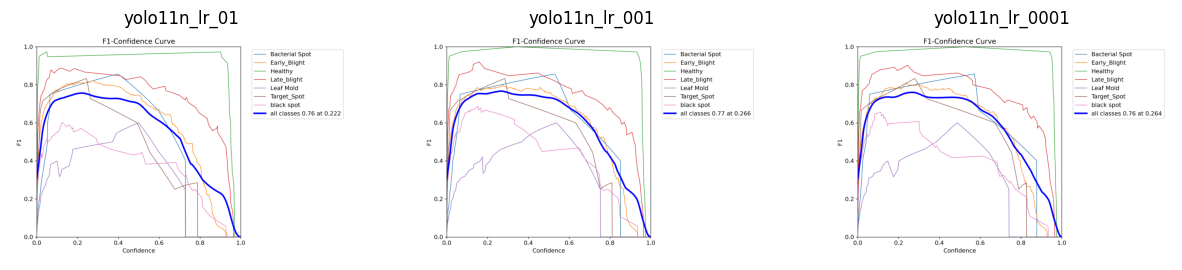

In [75]:
img_1 = mpimg.imread(f'/content/runs/detect/{run_names[0]}/F1_curve.png')
img_2 = mpimg.imread(f'/content/runs/detect/{run_names[1]}/F1_curve.png')
img_3 = mpimg.imread(f'/content/runs/detect/{run_names[2]}/F1_curve.png')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img_1)
axs[0].axis('off')
axs[0].set_title(run_names[0])
axs[1].imshow(img_2)
axs[1].axis('off')
axs[1].set_title(run_names[1])
axs[2].imshow(img_3)
axs[2].axis('off')
axs[2].set_title(run_names[2])

plt.show()

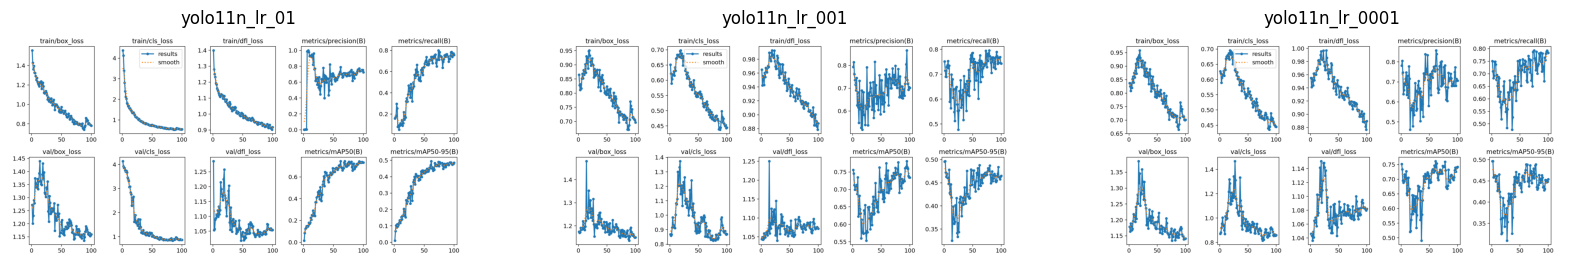

In [74]:
img_1 = mpimg.imread(f'/content/runs/detect/{run_names[0]}/results.png')
img_2 = mpimg.imread(f'/content/runs/detect/{run_names[1]}/results.png')
img_3 = mpimg.imread(f'/content/runs/detect/{run_names[2]}/results.png')

fig, axs = plt.subplots(1, 3, figsize=(20, 12))
axs[0].imshow(img_1)
axs[0].axis('off')
axs[0].set_title(run_names[0])
axs[1].imshow(img_2)
axs[1].axis('off')
axs[1].set_title(run_names[1])
axs[2].imshow(img_3)
axs[2].axis('off')
axs[2].set_title(run_names[2])

plt.show()

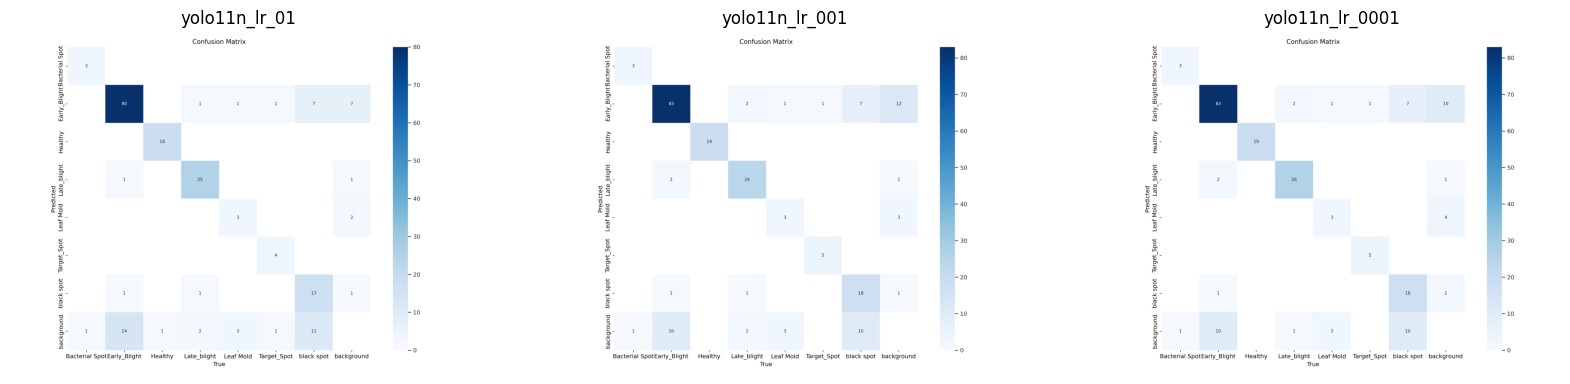

In [73]:
img_1 = mpimg.imread(f'/content/runs/detect/{run_names[0]}/confusion_matrix.png')
img_2 = mpimg.imread(f'/content/runs/detect/{run_names[1]}/confusion_matrix.png')
img_3 = mpimg.imread(f'/content/runs/detect/{run_names[2]}/confusion_matrix.png')

fig, axs = plt.subplots(1, 3, figsize=(20, 12))
axs[0].imshow(img_1)
axs[0].axis('off')
axs[0].set_title(run_names[0])
axs[1].imshow(img_2)
axs[1].axis('off')
axs[1].set_title(run_names[1])
axs[2].imshow(img_3)
axs[2].axis('off')
axs[2].set_title(run_names[2])

plt.show()

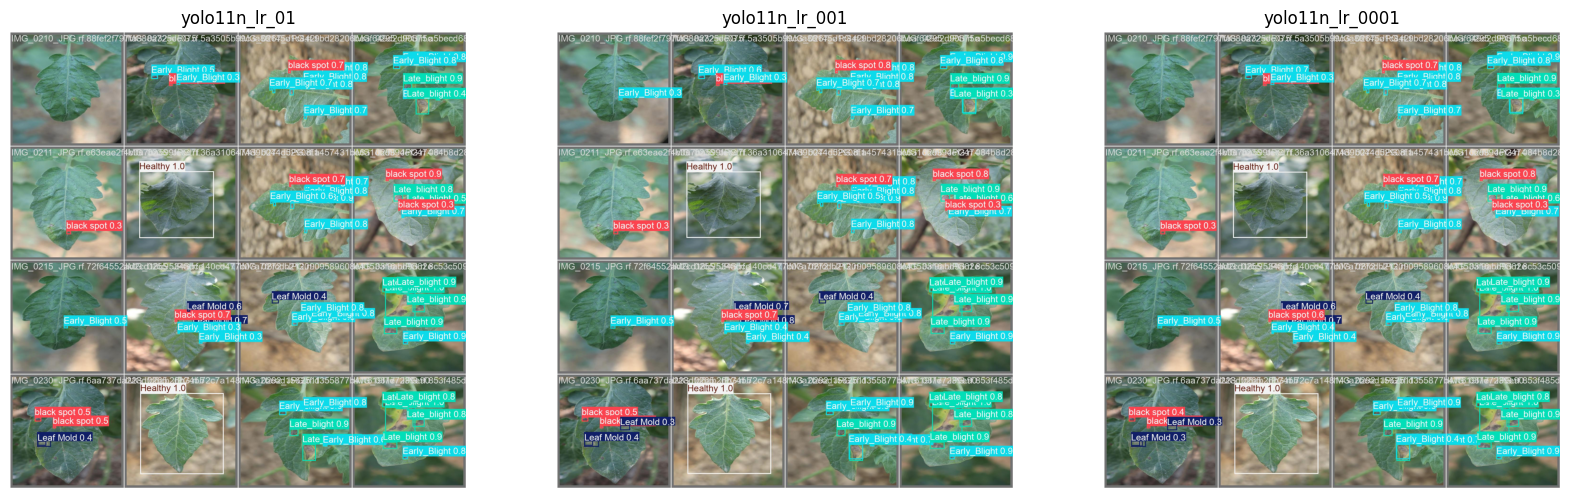

In [72]:
img_1 = mpimg.imread(f'/content/runs/detect/{run_names[0]}/val_batch0_pred.jpg')
img_2 = mpimg.imread(f'/content/runs/detect/{run_names[1]}/val_batch0_pred.jpg')
img_3 = mpimg.imread(f'/content/runs/detect/{run_names[2]}/val_batch0_pred.jpg')

fig, axs = plt.subplots(1, 3, figsize=(20, 12))
axs[0].imshow(img_1)
axs[0].axis('off')
axs[0].set_title(run_names[0])
axs[1].imshow(img_2)
axs[1].axis('off')
axs[1].set_title(run_names[1])
axs[2].imshow(img_3)
axs[2].axis('off')
axs[2].set_title(run_names[2])

plt.show()

I will use the 2nd model with lerning rate equal to 0.001

In [76]:
import shutil
from google.colab import files

shutil.make_archive('/content/yolo11n_lr_0001', 'zip', '/content/runs/detect/yolo11n_lr_0001')
files.download('/content/yolo11n_lr_0001.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
shutil.make_archive('/content/yolo11n_lr_001', 'zip', '/content/runs/detect/yolo11n_lr_001')
files.download('/content/yolo11n_lr_001.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
shutil.make_archive('/content/yolo11n_lr_01', 'zip', '/content/runs/detect/yolo11n_lr_01')
files.download('/content/yolo11n_lr_01.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Loading the model

In [91]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")  # load an official model
model = YOLO("/content/best.pt")  # load a custom model

In [ ]:
# # Validate the model
# metrics = model.val()  # no arguments needed, dataset and settings remembered
# metrics.box.map  # map50-95
# metrics.box.map50  # map50
# metrics.box.map75  # map75
# metrics.box.maps  # a list contains map50-95 of each category

## Comparance results


0: 640x640 1 Healthy, 16.5ms
Speed: 4.0ms preprocess, 16.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Early_Blights, 2 Late_blights, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Healthy, 16.4ms
Speed: 2.4ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


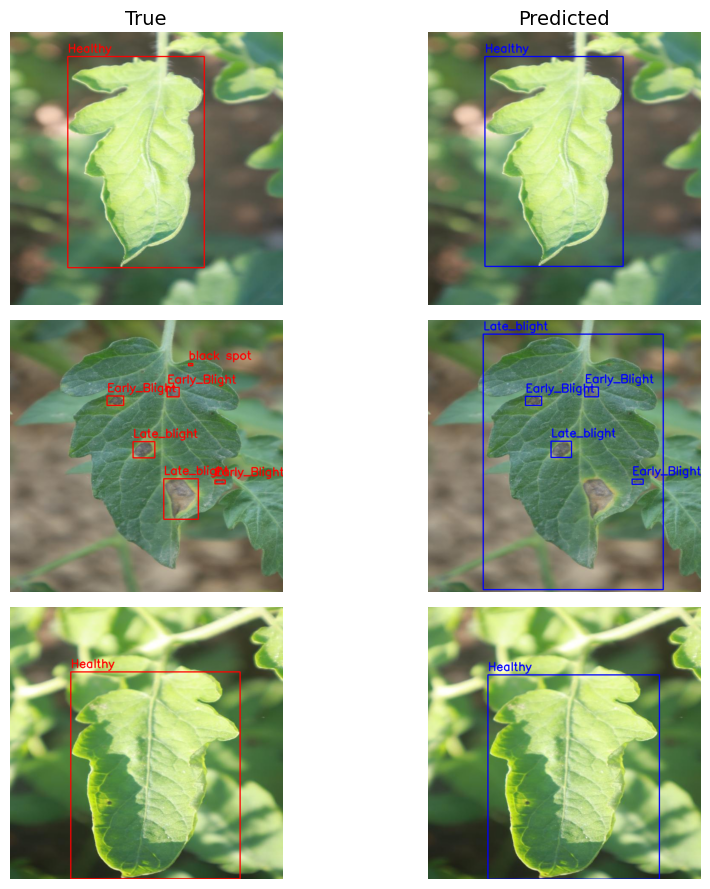

In [96]:
def plot_image_with_boxes(img_path, labels, class_names, ax):
    # Load image (assuming load_image is defined elsewhere)
    img = load_image(img_path)
    h, w, _ = img.shape
    for label in labels:
        class_idx, x, y, box_w, box_h = label
        box_w, box_h = int(box_w * w), int(box_h * h)
        x, y = int(x * w - box_w / 2), int(y * h - box_h / 2)
        img = cv2.rectangle(img, (x, y), (x + box_w, y + box_h), (255, 0, 0), 2)
        img = cv2.putText(img, class_names[int(class_idx)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image on the specified axis
    ax.imshow(img)
    ax.axis('off')


def plot_image_with_detected_boxes(img_path, model, ax):
    img = load_image(img_path)
    results = model.predict(source=img, save=False)
    for result in results:
        boxes = result.boxes.xyxy
        classes = result.boxes.cls
        for box, cls in zip(boxes, classes):
            x1, y1, x2, y2 = map(int, box)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            img = cv2.putText(img, class_names[int(cls)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    ax.imshow(img)
    ax.axis('off')
    # return img


# Set up the subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 9))

axs[0, 0].set_title("True", fontsize=14)
axs[0, 1].set_title("Predicted", fontsize=14)

for i in range(3):
    img_idx = np.random.randint(0, len(val_images))
    plot_image_with_boxes(val_images[img_idx], val_labels[img_idx], class_names, axs[i, 0])
    plot_image_with_detected_boxes(val_images[img_idx], model, axs[i, 1])

plt.tight_layout()  # To prevent overlap
plt.show()

# Displaing results

In [ ]:
def make_image_with_detected_boxes(img_path, model):
    img = load_image(img_path)
    results = model.predict(source=img, save=False)
    for result in results:
        boxes = result.boxes.xyxy
        classes = result.boxes.cls
        for box, cls in zip(boxes, classes):
            x1, y1, x2, y2 = map(int, box)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            img = cv2.putText(img, class_names[int(cls)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    return img

# Define the output directory
output_dir = 'test'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Plot and save images with detected boxes
for i, img_path in enumerate(test_images[:10]):
    img_with_boxes = make_image_with_detected_boxes(img_path, model)
    output_path = os.path.join(output_dir, f'sample_{i}.jpg')
    cv2.imwrite(output_path, cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR))

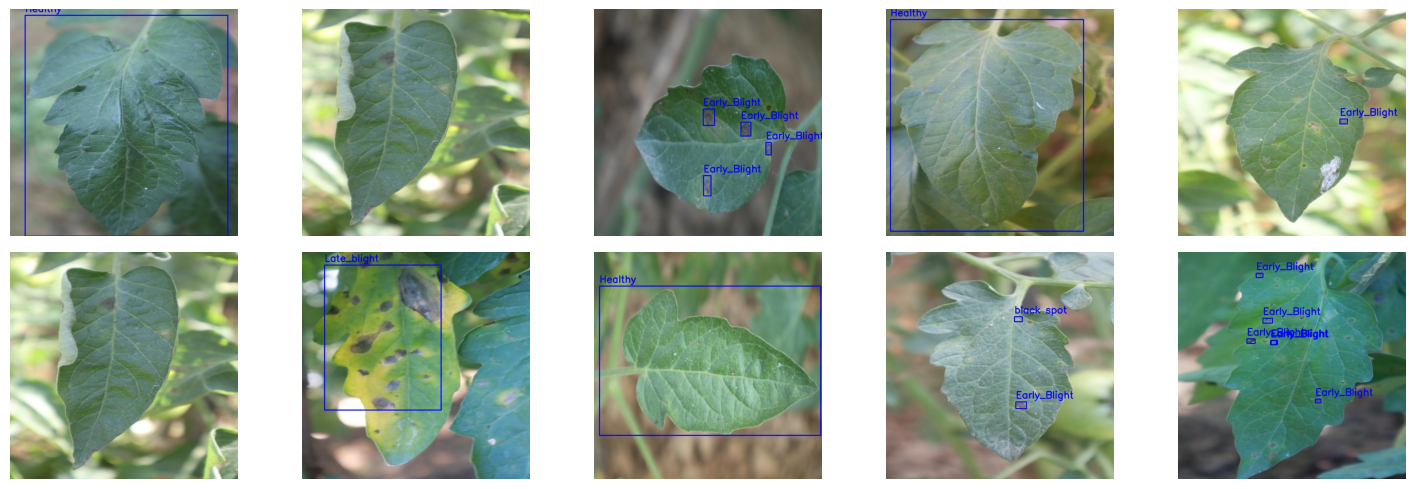

In [107]:
def load_image(img_path):
    img = Image.open(img_path)
    return np.array(img)

test_images = []
for img in os.listdir('/content/test'):
    img_path = '/content/test/' + img
    test_images.append(load_image(img_path))

# Set up the subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 5))

n = 0
for i in range(2):
    for j in range(5):
        ax = axs[i, j]
        ax.imshow(test_images[n])
        ax.axis('off')  # Hide axes
        n += 1

plt.tight_layout()  # To prevent overlap
plt.show()